In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
ROOT = '.data'

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True)

In [0]:

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [5]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13062754273414612
Calculated std: 0.30810779333114624


In [0]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])


In [0]:

train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

In [8]:

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [0]:

def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

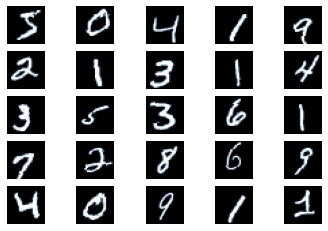

In [10]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [0]:

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples


In [0]:
train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [13]:

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


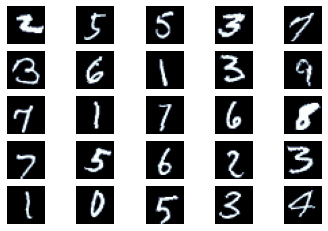

In [14]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [0]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

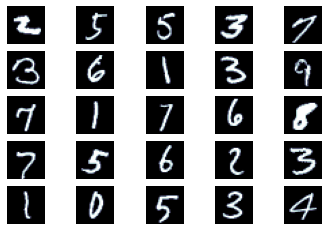

In [16]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [0]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [0]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        #x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        
        #y_pred = [batch size, output dim]
        
        return y_pred, h_2

In [0]:

INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 222,360 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())


In [0]:
criterion = nn.CrossEntropyLoss()


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [0]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
EPOCHS = 10

best_valid_loss = float('inf')
counter = 0
patience = 3

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut2-model.pt')
        counter = 0 
    else:
        counter += 1
        if counter >= patience:
            break
    

Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 0.423 | Train Acc: 86.83%
	 Val. Loss: 0.179 |  Val. Acc: 94.28%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.174 | Train Acc: 94.62%
	 Val. Loss: 0.122 |  Val. Acc: 96.28%
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.139 | Train Acc: 95.56%
	 Val. Loss: 0.114 |  Val. Acc: 96.36%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.117 | Train Acc: 96.42%
	 Val. Loss: 0.093 |  Val. Acc: 97.22%
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 0.112 | Train Acc: 96.62%
	 Val. Loss: 0.085 |  Val. Acc: 97.45%
Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.097 | Train Acc: 96.95%
	 Val. Loss: 0.076 |  Val. Acc: 97.27%
Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 0.095 | Train Acc: 97.01%
	 Val. Loss: 0.074 |  Val. Acc: 97.81%
Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 0.087 | Train Acc: 97.29%
	 Val. Loss: 0.072 |  Val. Acc: 97.82%
Epoch: 09 | Epoch Time: 0m 14s
	Train Loss: 0.084 | Train Acc: 97.40%
	 Val. Loss: 0.060 |  Val. Acc: 98.06%
Epoch: 10 | Epoch T

In [32]:
#model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Test Loss: 0.055 | Test Acc: 98.11%


In [0]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs


In [0]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [0]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

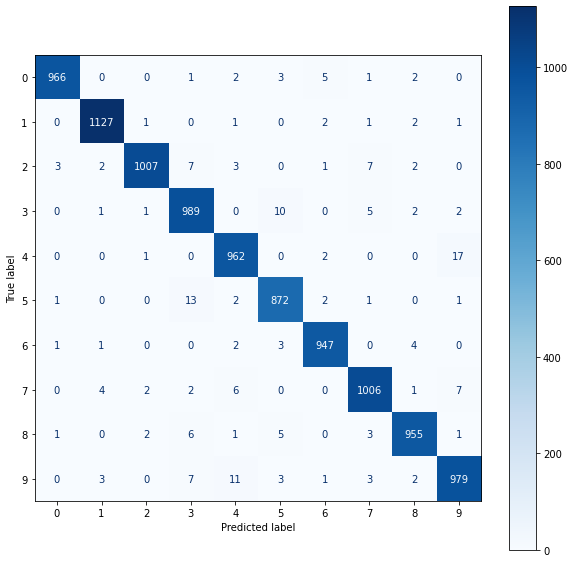

In [36]:
plot_confusion_matrix(labels, pred_labels)


In [0]:
corrects = torch.eq(labels, pred_labels)


In [0]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)


In [0]:

def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

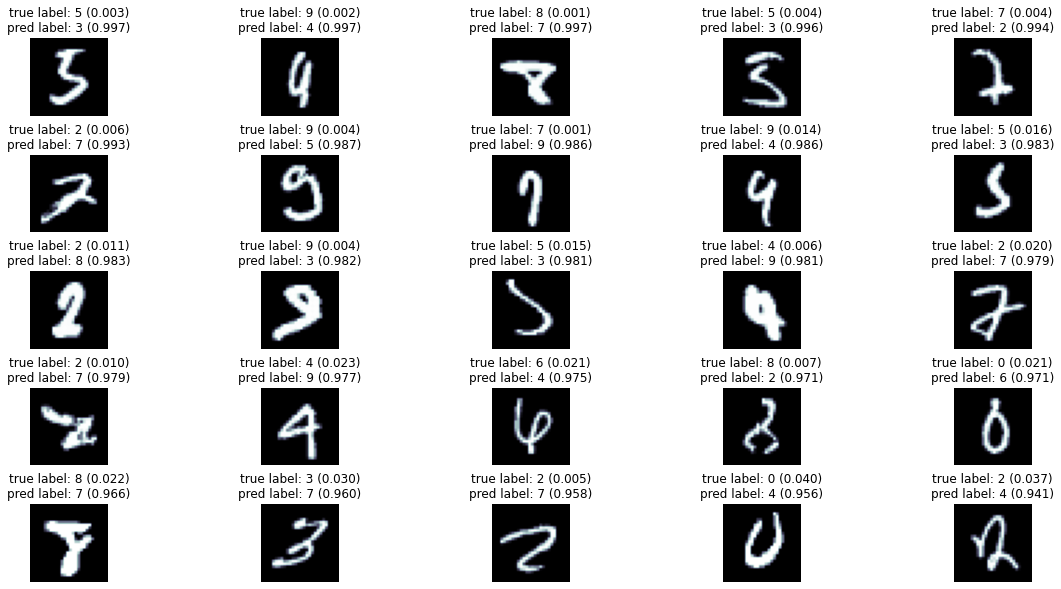

In [40]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [0]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels

In [0]:
outputs, intermediates, labels = get_representations(model, train_iterator, device)


In [0]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [0]:

def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

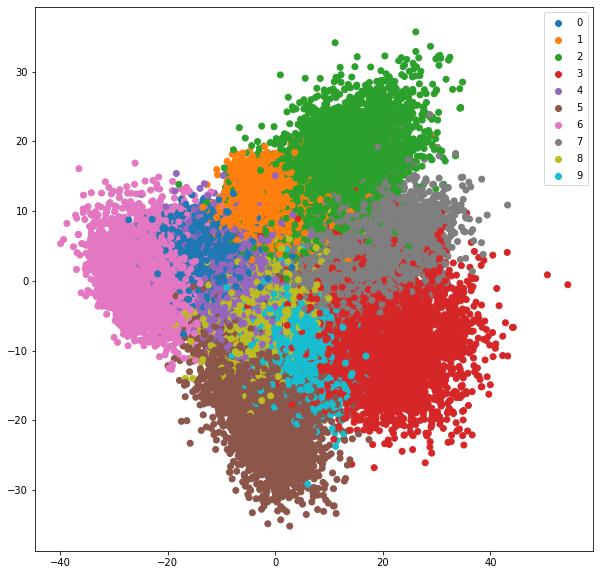

In [45]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

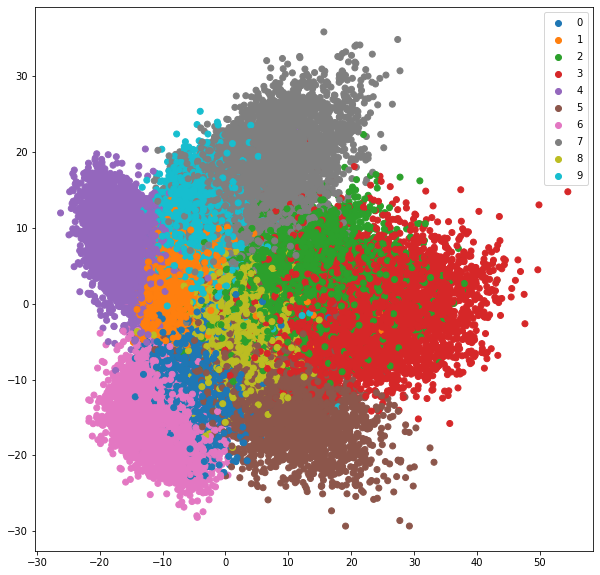

In [46]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

In [0]:

def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

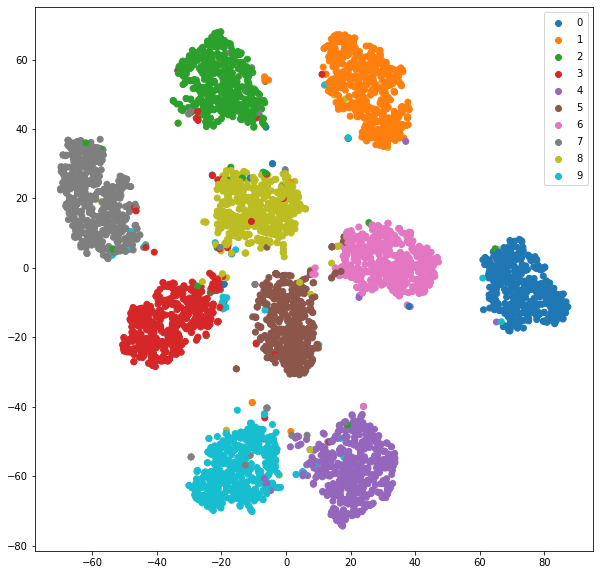

In [48]:

N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, n_images = N_IMAGES)

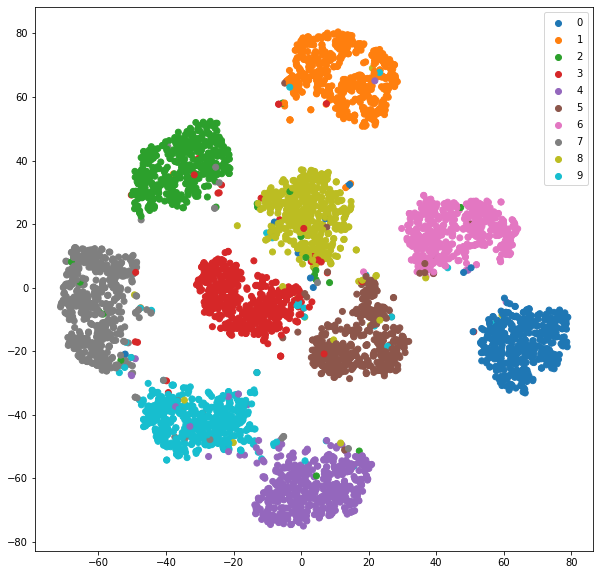

In [49]:
intermediate_tsne_data = get_tsne(intermediates, n_images = N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images = N_IMAGES)

In [0]:
def imagine_digit(model, digit, device, n_iterations = 50_000):

    model.eval()
    
    best_prob = 0
    best_image = None

    with torch.no_grad():
    
        for _ in range(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim = -1)

            _best_prob, index = torch.max(preds[:,digit], dim = 0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [0]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)


In [52]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')


Best image probability: 100.00%


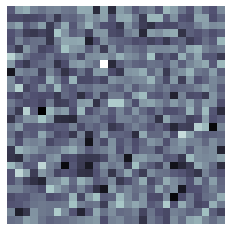

In [53]:
plt.imshow(best_image.cpu().numpy(), cmap = 'bone')
plt.axis('off');

In [0]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.axis('off')

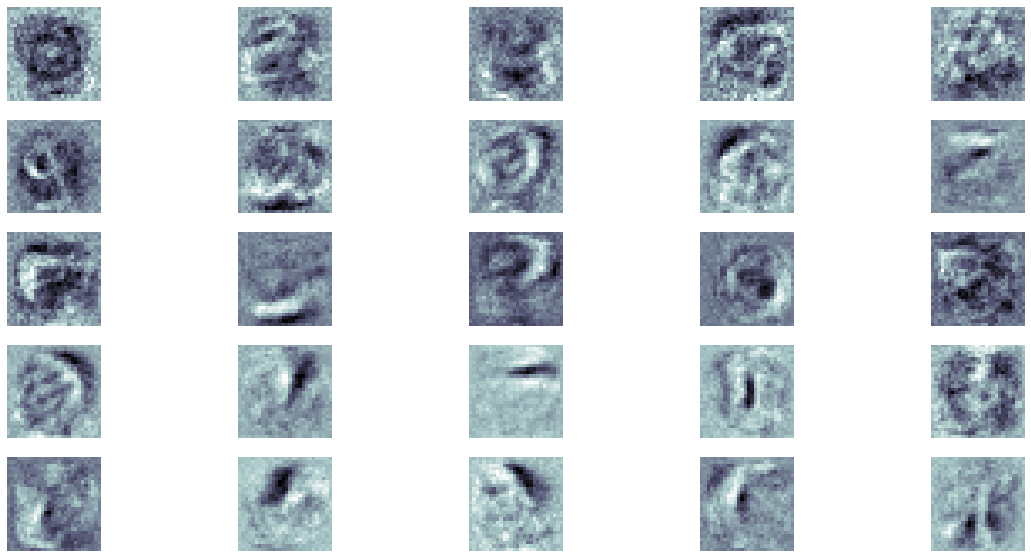

In [55]:
N_WEIGHTS = 25

weights = model.input_fc.weight.data

plot_weights(weights, N_WEIGHTS)